**AIRBNB Price Prediction Project.**
Authors-Nisarga Khairnair(nk1976@rit.edu) and Praharshita Kaithepalli(pk2971@rit.edu)

New York AirBNB data set taken from http://insideairbnb.com/get-the-data.html

## Data Processing

Importing important packages and data sets.

In [ ]:
import pandas as pd
import numpy as np
import sys
import time
import math
import seaborn as sns
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics
import lightgbm as lgb
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error
from sklearn import metrics
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score

Importing the data set and describing it.

In [ ]:
import pandas as pd
import numpy as np
from google.colab import files
import sys
sys.setrecursionlimit(40000)
upload=files.upload
df_listings=pd.read_csv('/content/listings.csv')

In [ ]:
df_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16922 entries, 0 to 16921
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            16922 non-null  int64  
 1   listing_url                                   16922 non-null  object 
 2   scrape_id                                     16922 non-null  int64  
 3   last_scraped                                  16922 non-null  object 
 4   name                                          16909 non-null  object 
 5   description                                   16886 non-null  object 
 6   neighborhood_overview                         10623 non-null  object 
 7   picture_url                                   16922 non-null  object 
 8   host_id                                       16922 non-null  int64  
 9   host_url                                      16922 non-null 

Here in this data set we can notice that a lot of features in the data type object. We need to change the data types and drop a few columns that are irrelevant to the prediction. Also we find out how many columns have null values and find a way to fill them in.

In [ ]:
df_listings.drop(['host_listings_count','host_total_listings_count','calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms','license','calendar_updated','bathrooms','minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm','maximum_nights_avg_ntm'], axis=1, inplace=True)
#dropping irrelavant columns.

In [ ]:
df_listings['price']=df_listings['price'].str.replace('$','')
df_listings['price']=df_listings['price'].str.replace(',','')
df_listings['price'] = df_listings['price'].astype('float')

Price has symbol "$" and comma. We delete them and change the data type to float.

In [ ]:
df_listings['bathrooms_text']=df_listings['bathrooms_text'].str.replace('bath','')
df_listings['bathrooms_text']=df_listings['bathrooms_text'].str.replace('s','')
df_listings['bathrooms_text']=df_listings['bathrooms_text'].str.replace('shared','')
df_listings['bathrooms_text']=df_listings['bathrooms_text'].str.replace('hared','')
df_listings['bathrooms_text']=df_listings['bathrooms_text'].str.replace('private','')
df_listings['bathrooms_text']=df_listings['bathrooms_text'].str.replace('S half-','')
df_listings['bathrooms_text'] = pd.to_numeric(df_listings['bathrooms_text'], errors='coerce')

Similarly even in bathrooms_text column we remove all the other words and leave just the number of bathrooms. We also fill the null values with the median of number of bathrooms

In [ ]:
df_listings.replace({'f': 0, 't': 1}, inplace=True)

Every column with true or false values will be replaced with zeroes and ones.

In [ ]:
df_listings['latitude'] = df_listings['latitude'].astype('float')
df_listings['longitude'] = df_listings['longitude'].astype('float')

In [ ]:
df_listings['accommodates'] = df_listings['accommodates'].replace('NaN',round(df_listings['accommodates'].median()))
df_listings['accommodates'] = df_listings['accommodates'].astype('int')

In [ ]:
df_listings['availability_30'] = df_listings['availability_30'].astype('int')
df_listings['availability_60'] = df_listings['availability_60'].astype('int')
df_listings['availability_90'] = df_listings['availability_90'].astype('int')
df_listings['availability_365'] = df_listings['availability_365'].astype('int')

In [ ]:
df_listings['number_of_reviews'] = df_listings['number_of_reviews'].astype('int')

Changing the data types of some more columns.

In [ ]:
df_listings['amenities']

0        ["Free street parking", "Heating", "TV", "Dedi...
1        ["Dedicated workspace", "Iron", "Stove", "Hair...
2        ["Kitchen", "Long term stays allowed", "Air co...
3        ["Dryer", "BBQ grill", "Kitchen", "Long term s...
4        ["Hot water", "Bed linens", "Extra pillows and...
                               ...                        
16917    ["Elevator", "Dishes and silverware", "Lockbox...
16918    ["Dishes and silverware", "Cooking basics", "L...
16919    ["Kitchen", "Wifi", "Hangers", "Shampoo", "Smo...
16920    ["Dedicated workspace", "Iron", "Stove", "Dish...
16921    ["Kitchen", "First aid kit", "Wifi", "Smoke al...
Name: amenities, Length: 16922, dtype: object

In [ ]:
df_listings['number_of_amenities'] = df_listings['amenities'].str.count(",")+1
df_listings['len_host_verifications'] = df_listings['host_verifications'].str.count(",")+1

We create new features as price might depend on the number of amenities offered and number of verifications that the host has.

In [ ]:
df_listings['host_acceptance_rate']=df_listings['host_acceptance_rate'].str.replace('%','')
df_listings['host_acceptance_rate']=df_listings['host_acceptance_rate'].astype('float')

In [ ]:
df_listings.host_response_time.value_counts()

within an hour        2919
within a few hours    1790
within a day          1332
a few days or more     730
Name: host_response_time, dtype: int64

In [ ]:
df_listings.neighbourhood_cleansed.value_counts()

Williamsburg          1440
Bedford-Stuyvesant    1262
Harlem                1041
Upper West Side        762
Bushwick               741
                      ... 
Bergen Beach             1
Whitestone               1
Tottenville              1
Throgs Neck              1
Mill Basin               1
Name: neighbourhood_cleansed, Length: 205, dtype: int64

In [ ]:
df_listings['host_response_time']=df_listings['host_response_time'].str.replace('within an hour','1')
df_listings['host_response_time']=df_listings['host_response_time'].str.replace('within a few hours','2')
df_listings['host_response_time']=df_listings['host_response_time'].str.replace('within a day','3')
df_listings['host_response_time']=df_listings['host_response_time'].str.replace('a few days or more','4')
df_listings['host_response_time']=df_listings['host_response_time'].fillna('3')
df_listings['host_response_time']=df_listings['host_response_time'].astype('int')

In [ ]:
df_listings['host_response_rate']=df_listings['host_response_rate'].str.replace('%','')
df_listings['host_response_rate']=df_listings['host_response_rate'].astype('float')

We change the host response rate to a different values to be able to use this column to predict.

In [ ]:
df_listings.isnull().sum()

id                                   0
listing_url                          0
scrape_id                            0
last_scraped                         0
name                                13
                                  ... 
instant_bookable                     0
calculated_host_listings_count       0
reviews_per_month                 2775
number_of_amenities                  0
len_host_verifications               0
Length: 62, dtype: int64

In [ ]:
df_listings['bathrooms_text'].fillna(round(df_listings['bathrooms_text'].median()),inplace=True)
df_listings['bedrooms']=df_listings['bedrooms'].fillna(2)
df_listings['beds']=df_listings['beds'].fillna(2)
df_listings['host_acceptance_rate'].fillna(round(df_listings['host_acceptance_rate'].median()),inplace=True)
df_listings['review_scores_rating']=df_listings['review_scores_rating'].fillna(round(df_listings['review_scores_rating'].mean()))
df_listings['review_scores_accuracy']=df_listings['review_scores_accuracy'].fillna(round(df_listings['review_scores_accuracy'].mean()))
df_listings['review_scores_cleanliness']=df_listings['review_scores_cleanliness'].fillna(round(df_listings['review_scores_cleanliness'].mean()))
df_listings['review_scores_checkin']=df_listings['review_scores_checkin'].fillna(round(df_listings['review_scores_checkin'].mean()))
df_listings['review_scores_communication']=df_listings['review_scores_communication'].fillna(round(df_listings['review_scores_communication'].mean()))
df_listings['review_scores_location']=df_listings['review_scores_location'].fillna(round(df_listings['review_scores_location'].mean()))
df_listings['review_scores_value']=df_listings['review_scores_value'].fillna(round(df_listings['review_scores_value'].mean()))
df_listings['reviews_per_month']=df_listings['reviews_per_month'].fillna(0.0)
df_listings['host_is_superhost']=df_listings['host_is_superhost'].fillna(0.0)
df_listings['host_response_rate']=df_listings['host_response_rate'].fillna(round(df_listings['host_response_rate'].median()))

All the null values in the important columns we need are filled now.

## Exploratory Data Analysis

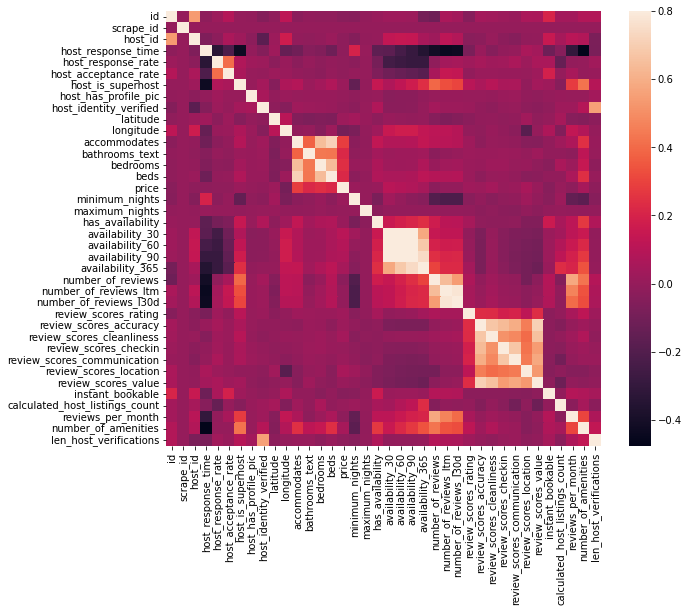

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
corrmat = df_listings.corr()
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corrmat, vmax=.8, square=True,xticklabels=True, yticklabels=True);

We plot a heat map to see the correlation between different features. We can see that some features like reviews_ltm , reviews_l30d and review_scores have too much corelation. We will create a single feature for reviews and we will drop all the other columns. We do the same with other features as well.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


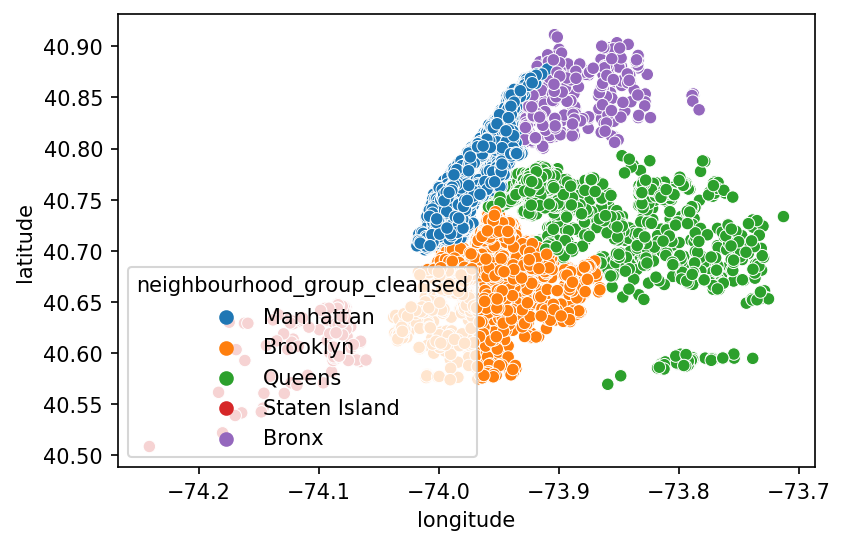

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4), dpi = 150)
sns.scatterplot(df_listings.longitude,df_listings.latitude,hue=df_listings.neighbourhood_group_cleansed)
plt.show()

We create a graph to plot the different airbnb listings depending on the latitude and longitude.

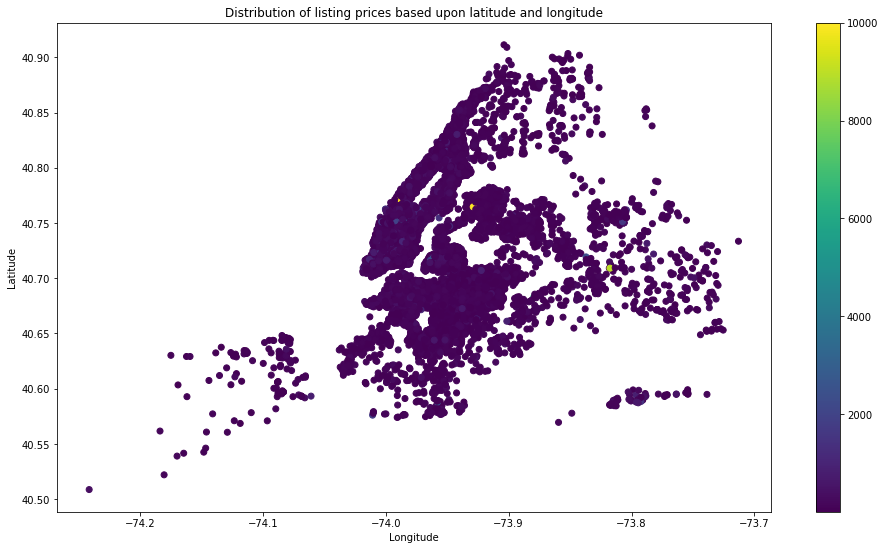

In [ ]:
import matplotlib.pyplot as plt
y = df_listings.latitude
x = df_listings.longitude
p = df_listings.price
plt.figure(figsize=(16,9))
plt.scatter(x,y,c=p,cmap='viridis')
plt.colorbar()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Distribution of listing prices based upon latitude and longitude")
plt.show()


We create similar plot as above but this time we can also show the price variations based upon the latitude and longitude. Here we notice that maybe due to outliers in the price there is no accurate representation of the price on the graph. These price outliers may also skew the data. We will work on removing these outliers below and we shall plot the same graph again to see any improvement.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


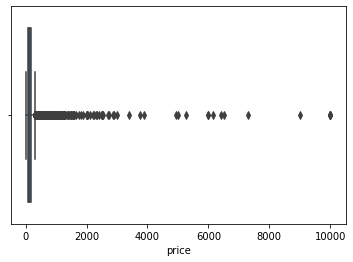

In [ ]:
sns.boxplot(df_listings['price'])

Here is a boxplot of the 'price'. We can see that there are outliers. The outliers will skew the data and can have an affect on the prediction.

In [ ]:
def outliers(data):
 sorted(data)
 Q1,Q3 = np.percentile(data , [25,75])
 IQR = Q3 - Q1
 lower = Q1 - (1.5 * IQR)
 upper = Q3 + (1.5 * IQR)
 
 return lower,upper

We will use the inter-quartile method to remove the outliers in the price.

In [ ]:
lower,upper = outliers(df_listings['price'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


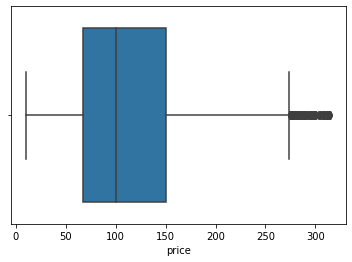

In [ ]:
df_listings = df_listings[(df_listings.price>lower) & (df_listings.price<upper)]
sns.boxplot(df_listings['price'])

Now that the outliers are removed and the boxplot is looking way better we will plot the prices against latitude and longitude again to see if we will get better and accurate graph.

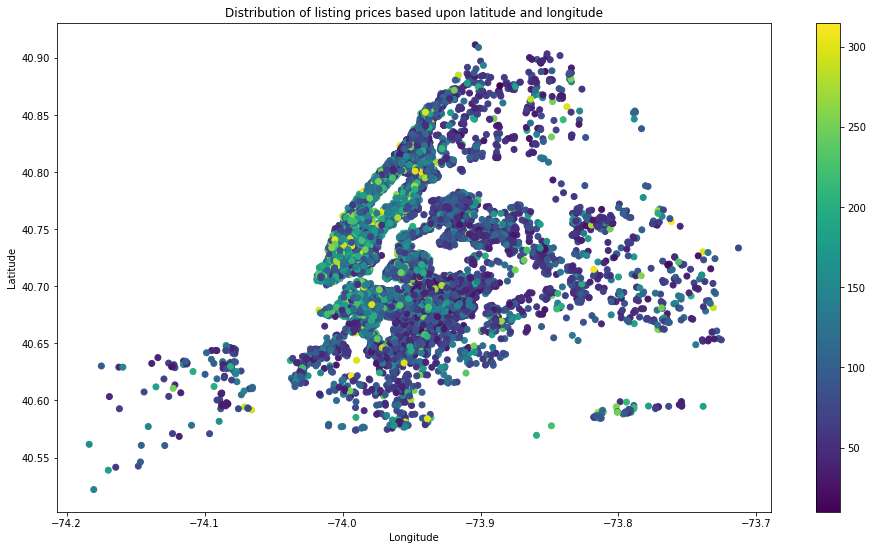

In [ ]:
y = df_listings.latitude
x = df_listings.longitude
p = df_listings.price
plt.figure(figsize=(16,9))
plt.scatter(x,y,c=p)
plt.colorbar()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Distribution of listing prices based upon latitude and longitude")
plt.show()


Now after the ouliers are removed and we plotted the same graph, we can see a more accurate representation of the prices in the graph.

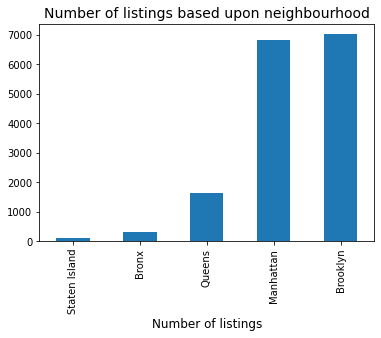

In [ ]:
import matplotlib.pyplot as plt
feq = df_listings['neighbourhood_group_cleansed'].value_counts().sort_values(ascending=True)
feq = feq[-25:]
feq.plot.bar()
plt.title('Number of listings based upon neighbourhood', fontsize=14)
plt.xlabel('Number of listings', fontsize = 12)
plt.show()

We can see that many AirBNB listings are located in the Manhattan and Brooklyn area. 
But will use the 'neighbourhood_cleansed' column in the prediction as it is more specific that 'neighbourhood_group_cleansed'.

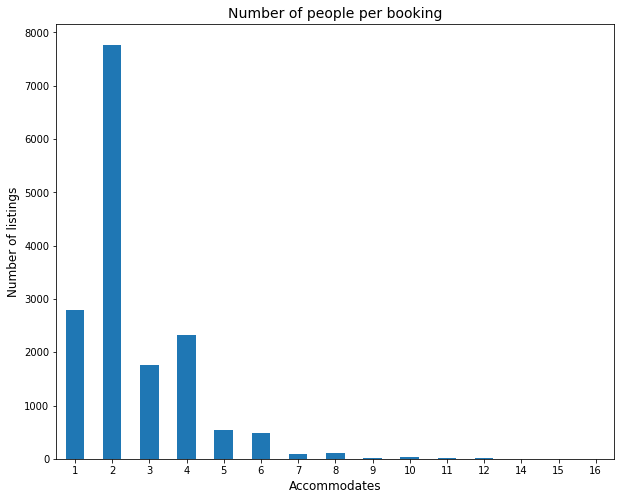

In [ ]:
feq = df_listings['accommodates'].value_counts().sort_index()
feq.plot.bar(figsize=(10,8), width=0.5, rot=0)
plt.title('Number of people per booking', fontsize=14)
plt.ylabel('Number of listings', fontsize=12)
plt.xlabel('Accommodates', fontsize=12)
plt.show()

Most of the time people want to book an AirBNB which accomodates 2 people. Fortunately there are no null values in the 'accommodates' column.

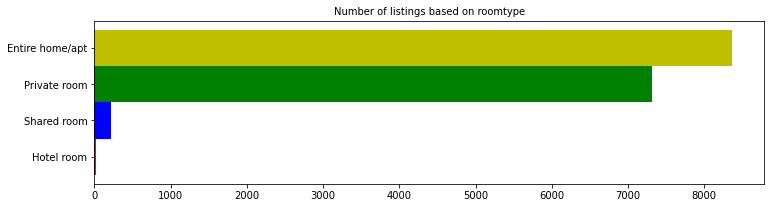

In [ ]:
freq = df_listings['room_type'].value_counts().sort_values(ascending=True)
freq.plot.barh(figsize =(12,3), width=1, color=['r','b','g','y'])
plt.title("Number of listings based on roomtype", fontsize=10)
plt.show()

Based upon the above graph we can see that most listings are entire home/appartments. We will also use 'room_type' column in prediction by using one-hot encoding.

## Feature Engineering

In [ ]:
df_listings.drop(['id','listing_url','scrape_id','last_scraped','name','picture_url','host_id','host_url','host_name','host_location','host_about','host_thumbnail_url','host_picture_url','host_neighbourhood','host_has_profile_pic','host_identity_verified','calendar_last_scraped'], axis=1, inplace=True)
df_listings.drop(['host_since','description','neighborhood_overview','amenities','neighbourhood_group_cleansed','neighbourhood','property_type','first_review','last_review','instant_bookable'], axis=1, inplace=True)
df_listings.drop(['host_verifications'], axis=1, inplace=True)

Dropping more unnecessary columns. Columns such as 'picture_url' and 'host_id' are totally irrerlevant to the predction of prices. Some more categorical data type columns such as 'neighbourhood_cleansed','amenities' have also been dropped.

In [ ]:
df_listings.isnull().sum()

host_response_time                0
host_response_rate                0
host_acceptance_rate              0
host_is_superhost                 0
neighbourhood_cleansed            0
latitude                          0
longitude                         0
room_type                         0
accommodates                      0
bathrooms_text                    0
bedrooms                          0
beds                              0
price                             0
minimum_nights                    0
maximum_nights                    0
has_availability                  0
availability_30                   0
availability_60                   0
availability_90                   0
availability_365                  0
number_of_reviews                 0
number_of_reviews_ltm             0
number_of_reviews_l30d            0
review_scores_rating              0
review_scores_accuracy            0
review_scores_cleanliness         0
review_scores_checkin             0
review_scores_communication 

In [ ]:
df_listings['review_score']=(df_listings['review_scores_rating']+df_listings['review_scores_accuracy']+df_listings['review_scores_checkin']+df_listings['review_scores_cleanliness']+df_listings['review_scores_communication']+df_listings['review_scores_location']+df_listings['review_scores_value'])/7
df_listings['reviews_last_month']=(df_listings['number_of_reviews_l30d']+df_listings['number_of_reviews_ltm'])/2

In [ ]:
df_listings.drop(['review_scores_rating','review_scores_accuracy','review_scores_checkin','review_scores_cleanliness','review_scores_communication','review_scores_location','review_scores_value','number_of_reviews_l30d','number_of_reviews_ltm'], axis=1, inplace=True)

As we saw in the above heatmap there were similar columns that had a lot of corelation. So we created new features and we dropped all the extra similar columns. Now we have only one column relating to the number of reviews last month and one column representing the review scores.

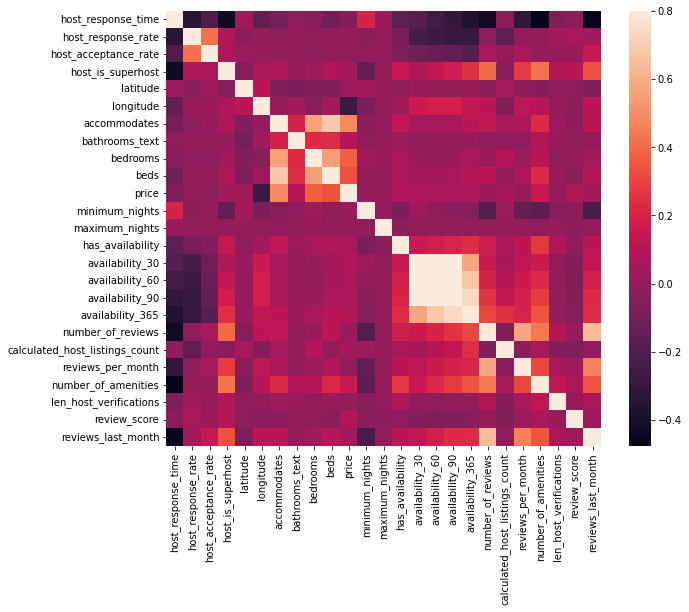

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
corrmat = df_listings.corr()
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corrmat, vmax=.8, square=True,xticklabels=True, yticklabels=True);

We plotted the heat map again after the outliers are removed and dropping some columns. We can see the corelation gets a little better.

In [ ]:
df_listings= pd.concat([df_listings, pd.get_dummies(df_listings['room_type'], drop_first=False)], axis=1)
df_listings.drop(['room_type'],axis=1, inplace=True)

In [ ]:
df_listings = pd.concat([df_listings, pd.get_dummies(df_listings['neighbourhood_cleansed'], drop_first=False)], axis=1)
df_listings.drop(['neighbourhood_cleansed'],axis=1, inplace=True)

We perform one-hot encoding here to create new features based up on the type of room and neighbourhood as price might depend on these two factors.

In [ ]:
X = df_listings.drop('price', axis=1)
y = df_listings.price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123) 
features = ['host_response_rate','host_response_time','host_acceptance_rate','host_is_superhost','latitude','longitude','accommodates','bathrooms_text','bedrooms','beds','minimum_nights','maximum_nights','has_availability','availability_30','availability_60','availability_90','availability_365','total_availability','calculated_host_listings_count','len_host_verifications','number_of_amenities','review_score','reviews_last_month']

Splitting data set into training and testing sets.
Then we use different regression models to predict the prices. We are going to print out the Mean Absolute error(MAE),Mean Square Error(MSE), Root Mean Square Error(RMSE) and R^2 value

In [ ]:
def perform_scoring(pred,actual):
  total = len(pred)
  correct_predictions = 0
  for i in range(0,len(pred)):
    if pred[i]-35<=actual.array[i] and actual.array[i] <= pred[i]+35:
      correct_predictions+=1
    else:
      continue
  return (correct_predictions/total)*100

## Model Building

**Linear Regressor**

In [ ]:
lr = LinearRegression()
lr.fit(X_train,y_train)
predict_lr = lr.predict(X_test)


In [ ]:
print("\nMAE:", round(mean_absolute_error(predict_lr,y_test)))
print("\nMSE:", round(mean_squared_error(y_test,predict_lr),4))
print("\nRMSE:", round(math.sqrt(mean_squared_error(y_test, predict_lr)),4))
print("\nR^2:", round(r2_score(y_test,predict_lr),4))


MAE: 36

MSE: 2434.9389

RMSE: 49.3451

R^2: 0.5401


In [ ]:
perform_scoring(predict_lr,y_test)

62.60780587633386

**Random Forest Regressor**

In [ ]:
rf = RandomForestRegressor(n_estimators=200)
rf.fit(X_train,y_train)
predict_rf = rf.predict(X_test)

In [ ]:
print("\nMAE:", round(mean_absolute_error(predict_rf,y_test)))
print("\nMSE:", round(mean_squared_error(y_test,predict_rf),4))
print("\nRMSE:", round(math.sqrt(mean_squared_error(y_test, predict_rf)),4))
print("\nR^2:", round(r2_score(y_test,predict_rf),4))


MAE: 30

MSE: 1830.152

RMSE: 42.7803

R^2: 0.6544


In [ ]:
perform_scoring(predict_rf,y_test)

69.91667884812162

**K-Neighbours Regressorr**

In [ ]:
knn=KNeighborsRegressor(algorithm='auto')
knn.fit(X_train,y_train)
predict_knn = knn.predict(X_test)

In [ ]:
print("\nMAE:", round(mean_absolute_error(predict_knn,y_test)))
print("\nMSE:", round(mean_squared_error(y_test,predict_knn),4))
print("\nRMSE:", round(math.sqrt(mean_squared_error(y_test, predict_knn)),4))
print("\nR^2:", round(r2_score(y_test,predict_knn),4))


MAE: 49

MSE: 4439.8106

RMSE: 66.6319

R^2: 0.1615


In [ ]:
perform_scoring(predict_knn,y_test)

48.063148662476245

**Gradient Boosting Regressor**

In [ ]:
gb = GradientBoostingRegressor(n_estimators=1000,learning_rate=0.05)
gb.fit(X_train,y_train)
predict_gb = gb.predict(X_test)

In [ ]:
print("\nMAE:", round(mean_absolute_error(predict_gb,y_test)))
print("\nMSE:", round(mean_squared_error(y_test,predict_gb),4))
print("\nRMSE:", round(math.sqrt(mean_squared_error(y_test, predict_gb)),4))
print("\nR^2:", round(r2_score(y_test,predict_gb),4))


MAE: 31

MSE: 1892.0396

RMSE: 43.4976

R^2: 0.6427


In [ ]:
perform_scoring(predict_gb,y_test)

68.6156994591434

**Light Gradient Boosting Machine Regressor**

In [ ]:
lgbmr = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=1000,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
lgbmr.fit(X_train,y_train)
predict_lgbmr = lgbmr.predict(X_test)


In [ ]:
print("\nMAE:", round(mean_absolute_error(predict_lgbmr,y_test)))
print("\nMSE:", round(mean_squared_error(y_test,predict_lgbmr),4))
print("\nRMSE:", round(math.sqrt(mean_squared_error(y_test, predict_lgbmr)),4))
print("\nR^2:", round(r2_score(y_test,predict_lgbmr),4))


MAE: 31

MSE: 1940.0043

RMSE: 44.0455

R^2: 0.6336


In [ ]:
perform_scoring(predict_lgbmr,y_test)

68.29410904838474

**Extreme Gradient Boosting Regressor**

In [ ]:
xgbr = xgb.XGBRegressor (nobjective='regression',n_estimators=1000,learning_rate=0.05)
xgbr.fit(X_train, y_train)
predict_xgbr = xgbr.predict(X_test)

[23:26:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
print("\nMAE:", round(mean_absolute_error(predict_xgbr,y_test)))
print("\nMSE:", round(mean_squared_error(y_test,predict_xgbr),4))
print("\nRMSE:", round(math.sqrt(mean_squared_error(y_test, predict_xgbr)),4))
print("\nR^2:", round(r2_score(y_test,predict_xgbr),4))



MAE: 31

MSE: 1891.7184

RMSE: 43.4939

R^2: 0.6427


In [ ]:
perform_scoring(predict_xgbr,y_test)

68.58646396725625

Adaboost

In [ ]:
from sklearn.ensemble import AdaBoostRegressor

In [ ]:
ada = AdaBoostRegressor(learning_rate = 0.08,n_estimators = 100)
ada.fit(X_train,y_train)
predict_ada = ada.predict(X_test)

In [ ]:
print("\nMAE:", round(mean_absolute_error(predict_ada,y_test)))
print("\nMSE:", round(mean_squared_error(y_test,predict_ada),4))
print("\nRMSE:", round(math.sqrt(mean_squared_error(y_test, predict_ada)),4))
print("\nR^2:", round(r2_score(y_test,predict_ada),4))


MAE: 44

MSE: 3050.5913

RMSE: 55.2322

R^2: 0.4239


Out of all XGB regressor is giving better prediction.

## Hyper Parameter Tuning

In [ ]:
y_array = np.array(list(y_test))
predict_xgbr_array = np.array(predict_xgbr)
df_values = pd.DataFrame({'Actual': y_array.flatten(), 'Predicted': predict_xgbr_array.flatten()})
df_values

,Actual,Predicted
0,83.0,112.075706
1,45.0,66.485313
2,40.0,24.092382
3,141.0,174.224060
4,125.0,155.533035
...,...,...
6836,120.0,148.715897
6837,120.0,124.684967
6838,64.0,84.842751
6839,110.0,108.585281


In [ ]:
dtrain_xgb = xgb.DMatrix(X_train, label=y_train)
dtest_xgb = xgb.DMatrix(X_test, label=y_test)

In [ ]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(9,12)
    for min_child_weight in range(5,8)
]

In [ ]:
min_mae = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("max_depth={},min_child_weight={}".format(max_depth,min_child_weight))
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    cv_results = xgb.cv(params,dtrain_xgb,num_boost_round=num_boost_round,seed=42,nfold=5,metrics={'mae'},early_stopping_rounds=10)
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE={},Rounds={}".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth,min_child_weight)
print("max_depth={}, min_child_weight={}, MAE={}".format(best_params[0], best_params[1], min_mae))
maxdepth=best_params[0]
minchildweight=best_params[1]


In [ ]:
params['max_depth'] = int(maxdepth)
params['min_child_weight'] =int(minchildweight)

In [ ]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

In [ ]:
min_mae = float("Inf")
best_params = None
for subsample, colsample in reversed(gridsearch_params):
    print("subsample={}, colsample={}".format(subsample,colsample))
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    cv_results = xgb.cv(params,dtrain_xgb,num_boost_round=num_boost_round,seed=42,nfold=5,metrics={'mae'},early_stopping_rounds=10)
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE={},Rounds={} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (subsample,colsample)
print("subsample={},colsample_bytree={},MAE={}".format(best_params[0], best_params[1], min_mae))
subsamplevalue=best_params[0]
colsamplevalue=best_params[1]

In [ ]:
params['subsample'] = subsamplevalue
params['colsample_bytree'] = colsamplevalue

In [ ]:
min_mae = float("Inf")
best_params = None
for eta in [.3, .2, .1, .05]:
    print("eta={}".format(eta))
    params['eta'] = eta
    cv_results = xgb.cv(params,dtrain_xgb,num_boost_round=num_boost_round,seed=42,nfold=5,metrics=['mae'],early_stopping_rounds=10)
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE={},rounds={}\n".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = eta
print("eta={}, MAE={}".format(best_params, min_mae))
etavalue=best_params


eta=0.3
[02:29:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:29:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:29:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:29:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:29:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	MAE=30.5365466,rounds=43

eta=0.2
[02:30:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:30:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:30:36] WARNING: /workspace/src/objective/regression_obj.cu:152: 

In [ ]:
params['eta'] = etavalue

In [ ]:
params

{'colsample_bytree': 0.7,
 'eta': 0.05,
 'eval_metric': 'mae',
 'max_depth': 9,
 'min_child_weight': 6,
 'objective': 'reg:linear',
 'subsample': 1.0}

In [ ]:
xgb_train = xgb.train(params,dtrain_xgb,num_boost_round=num_boost_round,evals=[(dtest_xgb, "Test")],early_stopping_rounds=10)
print("MAE={:.2f},rounds={}".format(xgb_train.best_score, model.best_iteration+1))

[02:43:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	Test-mae:115.683
Will train until Test-mae hasn't improved in 10 rounds.
[1]	Test-mae:109.939
[2]	Test-mae:104.49
[3]	Test-mae:99.2636
[4]	Test-mae:94.287
[5]	Test-mae:89.599
[6]	Test-mae:85.1728
[7]	Test-mae:80.9495
[8]	Test-mae:76.9672
[9]	Test-mae:73.1969
[10]	Test-mae:69.658
[11]	Test-mae:66.3319
[12]	Test-mae:63.2013
[13]	Test-mae:60.2724
[14]	Test-mae:57.5533
[15]	Test-mae:55.0219
[16]	Test-mae:52.6808
[17]	Test-mae:50.5136
[18]	Test-mae:48.5223
[19]	Test-mae:46.6814
[20]	Test-mae:45.0054
[21]	Test-mae:43.4736
[22]	Test-mae:42.0808
[23]	Test-mae:40.7997
[24]	Test-mae:39.6475
[25]	Test-mae:38.6047
[26]	Test-mae:37.6575
[27]	Test-mae:36.7996
[28]	Test-mae:36.0212
[29]	Test-mae:35.3352
[30]	Test-mae:34.722
[31]	Test-mae:34.1514
[32]	Test-mae:33.661
[33]	Test-mae:33.2055
[34]	Test-mae:32.7957
[35]	Test-mae:32.4307
[36]	Test-mae:32.1264
[37]	Test-mae:31.84

NameError: ignored

In [ ]:
num_boost_round = xgb_train.best_iteration + 1
best_model_xgb = xgb.train(params,dtrain_xgb,num_boost_round=num_boost_round,evals=[(dtest_xgb, "Test")])

In [ ]:
predict_xgbr = best_model_xgb.predict(dtest_xgb)


In [ ]:
print("\nMAE:", round(mean_absolute_error(predict_xgbr,y_test)))
print("\nMSE:", round(mean_squared_error(y_test,predict_xgbr),4))
print("\nRMSE:", round(math.sqrt(mean_squared_error(y_test, predict_xgbr)),4))
print("\nR^2:", round(r2_score(y_test,predict_xgbr),4))

In [ ]:
perform_scoring(predict_xgbr,y_test)

In [ ]:
y_array = np.array(list(y_test))
predict_xgbr_array = np.array(predict_xgbr)
df_values = pd.DataFrame({'Actual': y_array.flatten(), 'Predicted': predict_xgbr_array.flatten()})
df_values

In [ ]:
pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11685 sha256=24d85a95aa9c9b81ac893b4507ba0c198022744adf20b852ad52a4d1f6e0f215
  Stored in directory: /root/.cache/pip/wheels/fd/9b/71/f127d694e02eb40bcf18c7ae9613b88a6be4470f57a8528c5b
Successfully built bayesian-optimization


In [ ]:
from bayes_opt import BayesianOptimization

def xgbm_cl_bo(max_depth, learning_rate, n_estimators, gamma):
    params_xgbm = {}
    params_xgbm['max_depth'] = round(max_depth)
    params_xgbm['learning_rate'] = learning_rate
    params_xgbm['n_estimators'] = round(n_estimators)
    params_xgbm['gamma'] = gamma
    scores = cross_val_score(xgb.XGBRegressor(random_state=123, **params_gbm),
                             X_train, y_train, cv=5).mean()
    score = scores.mean()
    return score


start = time.time()
params_xgbm ={
    'max_depth':(3, 10),
    'learning_rate':(0.01, 1),
    'n_estimators':(80, 1500),
    'gamma': (0, 100)
}
xgbm_bo = BayesianOptimization(xgbm_cl_bo, params_xgbm, random_state=111)
xgbm_bo.maximize(init_points=20, n_iter=4)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... |
-------------------------------------------------------------------------
|  1        |  0.6427   |  61.22    |  0.1774   |  6.052    |  1.172e+0 |
|  2        |  0.6493   |  29.53    |  0.1577   |  3.157    |  676.7    |
|  3        |  0.6106   |  23.87    |  0.3443   |  9.935    |  417.6    |
|  4        |  0.538    |  8.119    |  0.6729   |  7.349    |  469.4    |
|  5        |  0.6565   |  46.62    |  0.1272   |  3.518    |  1.359e+0 |
|  6        |  0.4715   |  79.4     |  0.8422   |  8.706    |  1.487e+0 |
|  7        |  0.543    |  57.73    |  0.8156   |  5.949    |  119.0    |
|  8        |  0.6489   |  45.41    |  0.1143   |  8.721    |  1.071e+0 |
|  9        |  0.6245   |  56.53    |  0.2815   |  9.989    |  276.0    |
|  10       |  0.5879   |  61.54    |  0.4902   |  5.835    |  1.114e+0 |
|  11       |  0.6011   |  32.28    |  0.4065   |  5.233    |  1.425e+0 |
|  12       |  0.5474   |  91.87    | 

In [ ]:
xgbr = xgb.XGBRegressor (n_estimators=967,learning_rate=0.08,gamma=86,max_depth=9,objective='reg:linear')
xgbr.fit(X_train, y_train)
predict_xgbr = xgbr.predict(X_test)

[22:52:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
print("\nMAE:", round(mean_absolute_error(predict_xgbr,y_test)))
print("\nMSE:", round(mean_squared_error(y_test,predict_xgbr),4))
print("\nRMSE:", round(math.sqrt(mean_squared_error(y_test, predict_xgbr)),4))
print("\nR^2:", round(r2_score(y_test,predict_xgbr),4))


MAE: 29

MSE: 1760.6226

RMSE: 41.9598

R^2: 0.6675


In [ ]:
perform_scoring(predict_xgbr,y_test)

71.15918725332554